In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

# Normalization Run

In [3]:
#Simulation Cell size and resolution
sx = 20
sy = 16

res = 18

#waveguide parameters
wvg_width = 1
wvg_x = 0
wvg_y = -6

#refractive index
n = 1.7
silicon = mp.Medium(index=n)

#source parameters
fcen = 0.85
df = 0.5

src_x = -8
src_y = wvg_y

src_width = wvg_width

#Geometry
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf), center = mp.Vector3(wvg_x, wvg_y), material = mp.Medium(index=n))

#Sources
src = mp.Source(mp.GaussianSource(fcen, fwidth=df),
               mp.Ez,
               center=mp.Vector3(src_x, src_y),
                size=mp.Vector3(0, src_width)
               )

#Perfectly matched layers
pml_layers = [mp.PML(1.0)]

#Flux regions
inc_x = -2.5
inc_y = wvg_y

tr_x = 6
tr_y = wvg_y

inc_width = wvg_width

In [4]:
#Simulation
sim = mp.Simulation(cell_size=mp.Vector3(sx,sy),
                    boundary_layers=pml_layers,
                    geometry=[waveguide],
                    sources=[src],
                    resolution=res,)

In [5]:
# Incident FluxRegion and fluxes
inc_fr = mp.FluxRegion(center=mp.Vector3(inc_x, inc_y), size=mp.Vector3(0,inc_width,0))
inc = sim.add_flux(fcen, df, 100, inc_fr)

# Transmitted FluxRegion and fluxes
tr_fr = mp.FluxRegion(center=mp.Vector3(tr_x, tr_y), size=mp.Vector3(0,inc_width,0))
tr = sim.add_flux(fcen, df, 100, tr_fr)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000153065 s
Working in 2D dimensions.
Computational cell is 20 x 16 x 0 with resolution 18
     block, center = (0,-6,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.149573 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 184.27777777777777/200.0 = 92.1% done in 4.0s, 0.3s to go
on time step 6658 (time=184.944), 0.00060081 s/step
Normalizing field data...
run 0 finished at t = 200.0 (7200 timesteps)


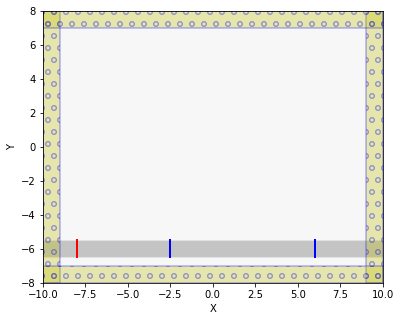

In [6]:
#Run simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       normalize=True,
                       fields=mp.Ez,
                       realtime=False,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})


sim.run(mp.at_every(1,animate), until=200)

In [7]:
animate.to_mp4(10, "Ez.mp4")

Video("Ez.mp4")

Generating MP4...


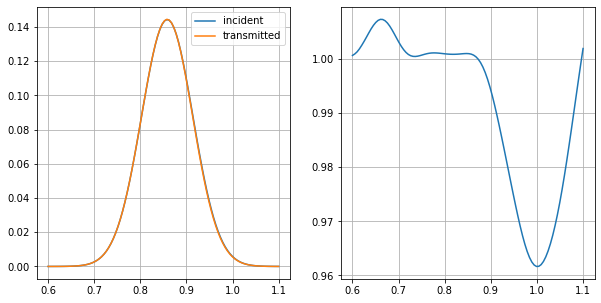

In [8]:
#Get fluxes, freqeuencies and plot
freqs = mp.get_flux_freqs(inc)

I_1 = mp.get_fluxes(inc)
T_1 = mp.get_fluxes(tr)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(freqs, I_1, label="incident")
ax1.plot(freqs, T_1, label="transmitted")
ax1.legend()
ax1.grid()

ax2.plot(freqs, np.array(T_1)/np.array(I_1))
ax2.grid()

#Get raw fluxes
I_1_raw = sim.get_flux_data(inc)

# Ring Resonator

In [9]:
sim.reset_meep()

In [10]:
# ring properties

d = 0.05

ring_w = 1 #ring width
ring_r = 4 #ring radius

ring_x = 0
ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

pad = 2 
dpml = 2

int_lim = 1e-3


In [11]:
#Ring Geometry

#define two cylinders
ext_ring = mp.Cylinder(radius=ring_r+ring_w, center=mp.Vector3(ring_x, ring_y), material=silicon)
int_ring = mp.Cylinder(radius=ring_r, center=mp.Vector3(ring_x, ring_y), material=mp.Medium(epsilon=1.0))


In [12]:

#Define simulation again
sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry =[ext_ring, int_ring, waveguide],
                   sources = [src],
                   resolution = res,
                    boundary_layers = pml_layers)

In [13]:
#Let's instruct Harminv where to check
'''pt = mp.Vector3(r+ w/2,0)
har = mp.Harminv(mp.Ez, pt, fcen, df)

sim.run(mp.after_sources(har),
        mp.at_every(50, mp.output_efield_z),
       until_after_sources = 400)
       '''

'pt = mp.Vector3(r+ w/2,0)\nhar = mp.Harminv(mp.Ez, pt, fcen, df)\n\nsim.run(mp.after_sources(har),\n        mp.at_every(50, mp.output_efield_z),\n       until_after_sources = 400)\n       '

In [14]:

# Incident FluxRegion and fluxes
inc_fr = mp.FluxRegion(center=mp.Vector3(inc_x, inc_y), size=mp.Vector3(0,inc_width,0))
inc = sim.add_flux(fcen, df, 100, inc_fr)

# Transmitted FluxRegion and fluxes
tr_fr = mp.FluxRegion(center=mp.Vector3(tr_x, tr_y), size=mp.Vector3(0,inc_width,0))
tr = sim.add_flux(fcen, df, 100, tr_fr)

# Subtract data for reflextion normalization
sim.load_minus_flux_data(inc, I_1_raw)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 2D dimensions.
Computational cell is 20 x 16 x 0 with resolution 18
     cylinder, center = (0,-0.45,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,-0.45,0)
          radius 4, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-6,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.288786 s
-----------


field decay(t = 50.02777777777777): 0.0008667511227514236 / 0.0008667511227514236 = 1.0
field decay(t = 100.05555555555554): 0.00832788401162652 / 0.00832788401162652 = 1.0
on time step 5025 (time=139.583), 0.000796068 s/step
field decay(t = 150.08333333333331): 0.003984344610583725 / 0.00832788401162652 = 0.47843421030134425
field decay(t = 200.1111111111111): 0.0016971806770062188 / 0.00832788401162652 = 0.2037949465478617
field decay(t = 250.13888888888889): 0.0007894213395084046 / 0.00832788401162652 = 0.09479254735131963
on time step 10152 (time=282), 0.000780733 s/step
field decay(t = 300.16666666666663): 0.0004005787234824064 / 0.00832788401162652 = 0.04810090089189046
field decay(t = 350.1944444444444): 0.00020190944350169425 / 0.00832788401162652 = 0.024244987468582585
field decay(t = 400.2222222222222): 0.0001259469838892651 / 0.00832788401162652 = 0.01512352762279483
on time step 15280 (time=424.444), 0.000780127 s/step
field decay(t = 450.25): 9.455140331638122e-05 / 0.0083

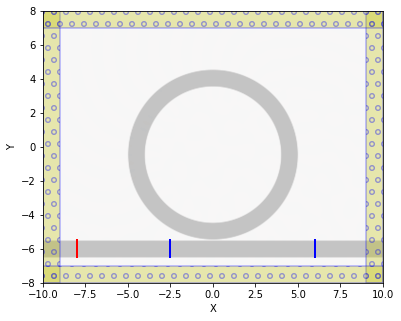

In [15]:
#Run simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       normalize=True,
                       fields=mp.Ez,
                       realtime=False,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

# point for stopping condition, inside ring
pt = mp.Vector3(ring_x, ring_y-ring_r-ring_w/2)

sim.run(mp.at_every(1,animate), until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

In [16]:
animate.to_mp4(10, "Ez.mp4")

Video("Ez.mp4")

Generating MP4...


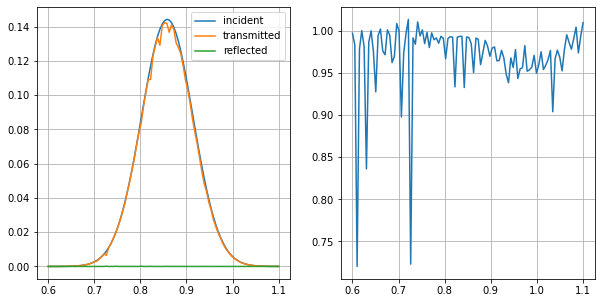

In [18]:
#Get fluxes, freqeuencies and plot
freqs = mp.get_flux_freqs(inc)

R_2 = mp.get_fluxes(inc)
T_2 = mp.get_fluxes(tr)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(freqs, I_1, label="incident")
ax1.plot(freqs, T_2, label="transmitted")
ax1.plot(freqs, R_2, label="reflected")
ax1.legend()
ax1.grid()

ax2.plot(freqs, np.array(T_2)/np.array(I_1))
ax2.grid()

# Harminv Rum

In [19]:
#Define simulation again
sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry =[ext_ring, int_ring, waveguide],
                   sources = [src],
                   resolution = res,
                    boundary_layers = pml_layers)

In [20]:
har = mp.Harminv(mp.Ez, pt, fcen, df)


In [21]:
sim.run(mp.after_sources(har),
        mp.at_every(50, mp.output_efield_z),
       until_after_sources = 400)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000633955 s
Working in 2D dimensions.
Computational cell is 20 x 16 x 0 with resolution 18
     cylinder, center = (0,-0.45,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,-0.45,0)
          radius 4, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-6,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.319104 s
-----------


FloatProgress(value=0.0, description='0% done ', max=420.0)

creating output file "./ez-000050.00.h5"...
creating output file "./ez-000100.00.h5"...
creating output file "./ez-000150.00.h5"...
Meep progress: 185.19444444444443/420.0 = 44.1% done in 4.0s, 5.1s to go
on time step 6678 (time=185.5), 0.000599044 s/step
creating output file "./ez-000200.00.h5"...
creating output file "./ez-000250.00.h5"...
creating output file "./ez-000300.00.h5"...
creating output file "./ez-000350.00.h5"...
Meep progress: 394.75/420.0 = 94.0% done in 8.0s, 0.5s to go
on time step 14224 (time=395.111), 0.000530137 s/step
creating output file "./ez-000400.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.6099068988482291, -0.0009576497470539703, 318.4394402674324, 5.9214620262641046e-05, -5.413566869151312e-05+2.399376227629809e-05i, 3.912170291397995e-06+0.0i
harminv0:, 0.6297045548128688, -0.0011678794278572773, 269.59313598330755, 0.00017736298538577675, -0.00016584197399571748-6.288138234930129e-05i, 3.7952884575698493e-06+0.0i
